# SAMPLING MOA USING MLSMOTE.

<b> Exploring MLSMOTE as a potential sampling technique to scale up the samples of tailend classes. There are many labels with few ~10 labels the aim is to scale them up to handle the class imbalance. Another way to solve it could be to playaround with wieghts. 

There is definately a huge class imbalance in this problem. But I didnt see any notebooks which handles this or any sampling techniques so the aim of this notebook is to use MLSMOTE: a synthetic data genration process for multilabel classification problems.

In [16]:
import sys
sys.path.append('../input/iterativestratification')

import numpy as np
import random
import pandas as pd
import os
import copy
import gc

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss

import warnings
warnings.filterwarnings('ignore')

os.listdir('../input/lish-moa')

pd.set_option('max_columns', 2000)

In [17]:
n_comp_GENES = 450
n_comp_CELLS = 2
VarianceThreshold_for_FS = 0.8
Dropout_Model = 0.25
print('n_comp_GENES', n_comp_GENES, 'n_comp_CELLS', n_comp_CELLS, 'total', n_comp_GENES + n_comp_CELLS)

n_comp_GENES 450 n_comp_CELLS 2 total 452


### 2.2 Previous commits <a class="anchor" id="2.2"></a>

[Back to Table of Contents](#0.1)

### It is recommended:
* **n_comp_GENES** smaller, 
* **n_comp_CELLS** more,
* **VarianceThreshold_for_FS** more, so that **train_features** is less.

## 3. Download data<a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [93]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

## 4. FE & Data Preprocessing <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [10]:
# GENES = [col for col in train_features.columns if col.startswith('g-')]
# CELLS = [col for col in train_features.columns if col.startswith('c-')]

### 4.1 RankGauss




In [11]:
# # RankGauss - transform to Gauss

# for col in (GENES + CELLS):

#     transformer = QuantileTransformer(n_quantiles=1000,random_state=0, output_distribution="normal")
#     vec_len = len(train_features[col].values)
#     vec_len_test = len(test_features[col].values)
#     raw_vec = train_features[col].values.reshape(vec_len, 1)
#     transformer.fit(raw_vec)

#     train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
#     test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

### 4.2 Seed<a class="anchor" id="4.2"></a>

[Back to Table of Contents](#0.1)

In [94]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

### 4.3 PCA features<a class="anchor" id="4.3"></a>

[Back to Table of Contents](#0.1)

In [13]:
# len(GENES)

772

In [14]:
# # GENES

# data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
# data2 = (TruncatedSVD(n_components=n_comp_GENES, random_state=42).fit_transform(data[GENES]))
# train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

# train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])
# test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])

# train_features = pd.concat((train_features, train2), axis=1)
# test_features = pd.concat((test_features, test2), axis=1)

In [15]:
# len(CELLS)

100

In [16]:
# # CELLS

# data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
# data2 = (TruncatedSVD(n_components=n_comp_CELLS, random_state=42).fit_transform(data[CELLS]))
# train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

# train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])
# test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])

# train_features = pd.concat((train_features, train2), axis=1)
# test_features = pd.concat((test_features, test2), axis=1)

In [17]:
# train_features.shape

(23814, 1328)

In [28]:
# train_features.head(5)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-67

### 4.4 FS by Variance Encoding<a class="anchor" id="4.4"></a>

[Back to Table of Contents](#0.1)

In [19]:
# var_thresh = VarianceThreshold(VarianceThreshold_for_FS)
# data = train_features.append(test_features)
# data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

# train_features_transformed = data_transformed[ : train_features.shape[0]]
# test_features_transformed = data_transformed[-test_features.shape[0] : ]


# train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
#                               columns=['sig_id','cp_type','cp_time','cp_dose'])

# train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


# test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
#                              columns=['sig_id','cp_type','cp_time','cp_dose'])

# test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

# train_features.shape

(23814, 1041)

In [20]:
# train_features.head(5)

,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,101

In [95]:
#train = train_features.merge(train_targets_scored, on='sig_id')
#train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features



In [ ]:
# train = train.drop('cp_type', axis=1)
# test = test.drop('cp_type', axis=1)

In [ ]:
# train.head(5)

In [96]:
target_cols = train_targets_scored.columns.values.tolist()
target_cols

['sig_id',
 '5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'akt_inhibitor',
 'aldehyde_dehydrogenase_inhibitor',
 'alk_inhibitor',
 'ampk_activator',
 'analgesic',
 'androgen_receptor_agonist',
 'androgen_receptor_antagonist',
 'anesthetic_-_local',
 'angiogenesis_inhibitor',
 'angiotensin_receptor_antagonist',
 'anti-inflammatory',
 'antiarrhythmic',
 'antibiotic',
 'anticonvulsant',
 'antifungal',
 'antihistamine',
 'antimalarial',
 'antioxidant',
 'antiprotozoal',
 'antiviral',
 'apoptosis_stimulant',
 'aromatase_inhibitor',
 'atm_kinase_inhibitor',
 'atp-sensitive_potassium_channel_antagonist',
 'atp_synthase_inhibitor',
 'atpase_inhibitor',
 'atr_kinase_inhibitor',
 'aurora_kinase_inh

In [ ]:
# tail = train[target_cols].sum() 

In [ ]:
# tail_cols = tail[tail<20]

In [ ]:
# tail_cols = tail_cols.index

In [97]:
train_targets_scored = train_targets_scored.drop('sig_id', axis=1)
train_targets_scored

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,re

In [98]:
target_cols = train_targets_scored.columns.values.tolist()
target_cols

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist',
 'adrenergic_receptor_antagonist',
 'akt_inhibitor',
 'aldehyde_dehydrogenase_inhibitor',
 'alk_inhibitor',
 'ampk_activator',
 'analgesic',
 'androgen_receptor_agonist',
 'androgen_receptor_antagonist',
 'anesthetic_-_local',
 'angiogenesis_inhibitor',
 'angiotensin_receptor_antagonist',
 'anti-inflammatory',
 'antiarrhythmic',
 'antibiotic',
 'anticonvulsant',
 'antifungal',
 'antihistamine',
 'antimalarial',
 'antioxidant',
 'antiprotozoal',
 'antiviral',
 'apoptosis_stimulant',
 'aromatase_inhibitor',
 'atm_kinase_inhibitor',
 'atp-sensitive_potassium_channel_antagonist',
 'atp_synthase_inhibitor',
 'atpase_inhibitor',
 'atr_kinase_inhibitor',
 'aurora_kinase_inhibitor',
 '

In [10]:
# train = train.drop('cp_type', axis=1)
# train

NameError: name 'train' is not defined

In [99]:
train = train_features
# removing cases when cp_type is ctl_vehicle
#train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
# transform the TWO categorical variables into numerical variables
# this is label encoding, may try one hot encoding later
train['cp_time'] = train['cp_time'].map({24:0, 48:1, 72:2})
train['cp_dose'] = train['cp_dose'].map({'D1':0,'D2':1})
train['cp_type'] = train['cp_type'].map({'trt_cp':0,'ctl_vehicle':1})
#make id index
#train = train.set_index(['sig_id'])

GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

def remove_outliers(col):
    col[col>3]=3
    col[col<-3]=-3
    return col
train=train.iloc[:,1:].apply(remove_outliers)
train_c=train.loc[:, CELLS]
x = StandardScaler().fit_transform(train_c)
pca_c = PCA(n_components=50)
principalComponents = pca_c.fit_transform(x)
principalDf_c = pd.DataFrame(data = principalComponents)

train_g=train.loc[:, GENES]
x = StandardScaler().fit_transform(train_g)
pca_g = PCA(n_components=500)
principalComponents = pca_g.fit_transform(x)
principalDf_g = pd.DataFrame(data = principalComponents)

pca_c=principalDf_c.iloc[:,:26]
names=[]
for i in range(1,27):
    var='pca_c'+str(i)
    names.append(var)
pca_c.columns=names

pca_g=principalDf_g.iloc[:,:240]
names=[]
for i in range(1,241):
    var='pca_g'+str(i)
    names.append(var)
pca_g.columns=names



pca_cg=pd.merge(pca_c, pca_g, left_index=True, right_index=True)
train_pca = pd.merge(train.iloc[:,:3], pca_cg, left_index=True, right_index=True)
train_pca = train_pca.drop('cp_type',axis = 1)
train_pca
train_pca, X_holdout, train_targets_scored, y_holdout = train_test_split(
    train_pca, train_targets_scored, test_size=0.2, random_state=74)



In [100]:
train_pca

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240
6442,0,0,0.618584,0.895652,-0.078543,-2.567235,2.663929,0.733189,1.190189,-1.186109,-0.166103,0.645890,0.859941,-0.137224,0.068597,0.566742,1.072779,-0.181075,-0.481391,0.219145,1.465236,0.551080,0.216168,1.136816,0.299477,0.413639,0.037826,0.947122,14.487712,9.892940,1.338049,-9.935396,6.066117,7.541041,-8.930466,-0.877175,1.929717,-3.450962,-1.047108,-3.634672,-4.711049,4.025350,-6.571076,4.937316,-1.910209,1.876655,4.126480,4.558193,-3.808828,-2.090859,0.938406,-1.372759,-1.913832,1.358773,0.243073,-2.006413,0.661804,-3.316538,1.188877,0.800081,0.755394,-0.447731,-0.470425,0.140128,-3.629580,-0.502657,-1.004018,0.086751,-0.631835,-0.876065,0.034092,-0.034505,-1.456518,0.052338,0.307367,-3.309150,1.076255,0.362494,0.998419,0.594370,1.956923,-1.277686,-0.832274,1.818027,-0.534886,0.090092,1.348996,0.497598,0.626515,0.323982,1.029753,-0.371169,-2.332328,-1.038192,-1.105449,-0.110513,0.535916,-1.065108,2.071628,-0.069254,-0.267530,-0.968127,-0.918900,2.205491,-0.043394,-0.906560,-0.938318,-0.548830,1.506504,0.402673,0.667795,0.230317,-0.234975,-0.710764,0.477273,-1.344423,-0.493921,0.218423,-0.857173,1.124060,0.974110,1.098912,2.463104,0.153213,1.826261,-0.026249,0.213697,0.507489,0.724249,0.366039,-0.890060,0.052754,0.179318,-0.322137,-0.620370,0.070455,0.886868,0.736768,0.614350,0.282981,-1.401819,1.148518,0.747970,0.513312,1.002308,-2.449986,1.743709,-0.206980,0.789000,-0.251478,-0.287184,1.010265,1.560077,-0.502555,-2.344880,0.210179,-2.291495,1.203674,-0.215198,-0.334231,0.839933,-1.372111,-0.092357,0.187776,0.484542,1.474498,-1.153843,0.336575,1.043979,-0.025675,2.315222,0.783883,0.722325,1.349302,-0.285253,-0.023351,0.502518,0.278239,0.496554,-0.208486,0.025903,0.905929,-1.023042,0.253103,-1.63622

In [103]:
train_features = train_pca.columns
train_features

Index(['cp_time', 'cp_dose', 'pca_c1', 'pca_c2', 'pca_c3', 'pca_c4', 'pca_c5',
       'pca_c6', 'pca_c7', 'pca_c8',
       ...
       'pca_g231', 'pca_g232', 'pca_g233', 'pca_g234', 'pca_g235', 'pca_g236',
       'pca_g237', 'pca_g238', 'pca_g239', 'pca_g240'],
      dtype='object', length=268)

# MLSMOTE

In [104]:
import numpy as np
import pandas as pd
import random

from sklearn.neighbors import NearestNeighbors


def get_tail_label(df):
    """
    fixed the columns of interest here  not the best solution but working on it.
    
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[0]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label # maybe hardcode this or improve it as it is not producing the required labels

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=120 ,metric='euclidean',algorithm='kd_tree').fit(X) # should be 206 here
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target



,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240
0,0,0,-4.817148,1.063604,-0.590042,-0.589412,-1.070739,-0.554014,-0.449915,0.114656,0.287163,-0.118906,-0.497140,-0.700508,-0.240309,0.071003,1.023643,0.072374,0.267896,-1.047416,-0.345122,-0.372317,0.056935,-0.738348,0.252957,0.998005,0.495637,-0.127938,-6.295220,2.922004,6.742391,4.666259,-7.281748,-0.285906,-0.300329,4.317643,0.741326,0.623688,1.661721,-0.115387,-1.306856,-0.779594,0.892798,0.301977,-0.229010,-0.091207,1.784190,0.427939,0.139105,-0.161890,1.236757,-1.568492,1.044828,-0.196303,1.147664,1.588240,1.135363,-0.036566,0.514804,0.483165,0.550115,-0.063663,0.075427,-0.877804,-0.210637,2.230069,1.061383,-1.094520,1.024596,-0.493047,-0.313351,0.494644,0.204824,0.040164,-0.224552,0.776911,-0.235052,0.382934,0.051630,0.764292,1.204654,0.530202,1.254774,0.325096,-0.060280,-2.350269,-0.272169,-0.666030,0.167955,-0.238324,1.364219,0.988853,1.609703,1.462329,-0.434041,0.250447,-0.275564,0.684529,0.700384,1.109327,0.800937,1.399167,-1.152627,-0.949332,-1.145212,-1.112836,-0.973420,0.710723,0.210156,1.565480,0.186140,-0.247995,-0.469346,0.040137,0.751674,0.584381,-0.148960,0.304135,-0.460585,0.342539,0.716149,1.651677,-1.258346,-1.130147,1.050335,0.516026,-0.361687,0.182765,0.363122,-0.716891,-0.412415,-0.716826,0.345182,-0.587505,-2.235736,1.084203,-0.377059,-0.611045,-1.561654,0.468842,1.015942,-2.389240,-1.029968,-0.912513,0.017611,1.337249,1.082445,-0.505446,-0.159815,0.319581,-0.461338,-0.157495,-0.774548,-0.681348,0.062530,0.747954,0.581197,-1.805314,-1.020061,0.593532,0.823442,0.165630,0.240301,0.221590,-0.621163,-0.689828,0.356661,0.052488,0.626751,-0.733098,0.934751,-0.106348,-0.628110,-2.150518,-0.318367,-1.618460,0.415160,1.656359,0.417173,1.142967,-0.313031,1.368040,0.072566,0.523369,-0.61

In [106]:
train_pca = train_pca.reset_index(drop = True)
train_pca
feature_cols = train_pca.columns
feature_cols

Index(['cp_time', 'cp_dose', 'pca_c1', 'pca_c2', 'pca_c3', 'pca_c4', 'pca_c5',
       'pca_c6', 'pca_c7', 'pca_c8',
       ...
       'pca_g231', 'pca_g232', 'pca_g233', 'pca_g234', 'pca_g235', 'pca_g236',
       'pca_g237', 'pca_g238', 'pca_g239', 'pca_g240'],
      dtype='object', length=268)

In [107]:
train_targets_scored = train_targets_scored.reset_index(drop = True)
train_targets_scored

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,re

In [108]:
#train_s = train.drop(['sig_id'] , axis = 1)

#train_s = pd.get_dummies(train_s, columns=['cp_time','cp_dose'])


X= train_pca
y = train_targets_scored#Creating a Dataframe
X_sub, y_sub = get_minority_instace(X, y)   #Getting minority instance of that datframe
X_res,y_res =MLSMOTE(X_sub, y_sub, 500)     #Applying MLSMOTE to augment the dataframe


In [36]:
# get_tail_label(y)

KeyError: 1

In [46]:
# columns = y.columns
# columns
# n = len(columns)
# irpl = np.zeros(n)
# y[columns[column]].value_counts()


0    19051
Name: erbb2_inhibitor, dtype: int64

In [109]:
X_res
y_res

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,re

In [112]:
X_holdout.reset_index(drop=True , inplace= True)
y_holdout.reset_index(drop=True , inplace= True)

In [113]:
y_holdout

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,re

In [111]:
X_res.reset_index(drop=True , inplace= True)
y_res.reset_index(drop=True , inplace= True)

In [19]:
# train_targets_scored.shape
# train_pca.shape

(23814, 268)

In [ ]:
# train = train.drop(['sig_id'] , axis =1)
# train = pd.get_dummies(train, columns=['cp_time','cp_dose'])

In [114]:
train_res = pd.concat([X_res, y_res] , axis=1 )

In [115]:
train_pca= pd.concat([train_pca, train_targets_scored] , axis=1 )

In [116]:
train_res

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrof

In [117]:
train_pca

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrof

In [56]:
# original train data set
# target_f =  train[target_cols]
# top_targets = pd.Series(target_f.sum()).sort_values(ascending=False)[:5]
# bottom_targets = pd.Series(target_f.sum()).sort_values()[:5]
# fig, axs = plt.subplots(figsize=(9,9) , nrows=2)
# sns.barplot(top_targets.values , top_targets.index , ax = axs[0] ).set(title = "Top five targets")
# sns.barplot(bottom_targets.values , bottom_targets.index, ax = axs[1] ).set(title = "bottom five targets")
# plt.show()

KeyError: "None of [Index(['5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor',\n       'acat_inhibitor', 'acetylcholine_receptor_agonist',\n       'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor',\n       'adenosine_receptor_agonist', 'adenosine_receptor_antagonist',\n       'adenylyl_cyclase_activator', 'adrenergic_receptor_agonist',\n       ...\n       'tropomyosin_receptor_kinase_inhibitor', 'trpv_agonist',\n       'trpv_antagonist', 'tubulin_inhibitor', 'tyrosine_kinase_inhibitor',\n       'ubiquitin_specific_protease_inhibitor', 'vegfr_inhibitor', 'vitamin_b',\n       'vitamin_d_receptor_agonist', 'wnt_inhibitor'],\n      dtype='object', length=206)] are in the [columns]"

In [ ]:
# # only tail_cols
# target_f =  train_res[get_tail_label(y)]
# top_targets = pd.Series(target_f.sum()).sort_values(ascending=False)[:5]
# bottom_targets = pd.Series(target_f.sum()).sort_values()[:5]
# fig, axs = plt.subplots(figsize=(9,9) , nrows=2)
# sns.barplot(top_targets.values , top_targets.index , ax = axs[0] ).set(title = "Top five targets")
# sns.barplot(bottom_targets.values , bottom_targets.index, ax = axs[1] ).set(title = "bottom five targets")
# plt.show()

In [ ]:
#definately an improvent for class imbalace 
# still need to fix this for bottom 2 instances though any ideas here would be great

In [118]:
train_res_f = train_pca.append(train_res)

In [119]:
train_res_f

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrof

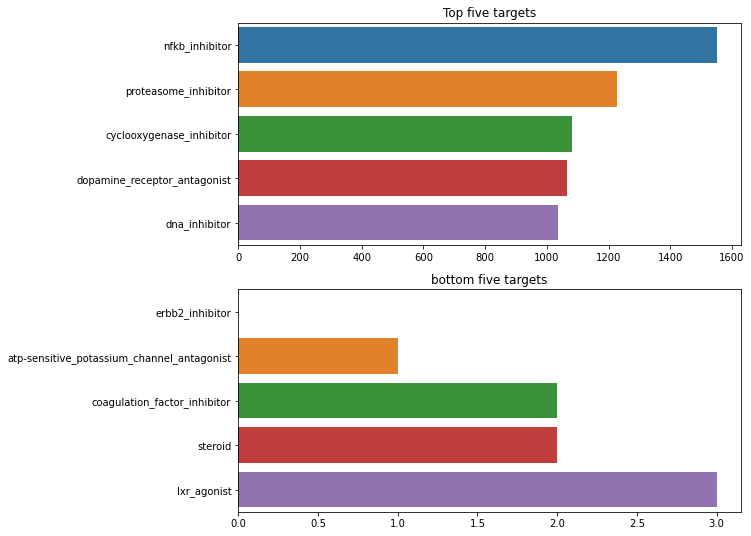

In [120]:
target_cols = train_targets_scored.columns.values.tolist()

#final_df
target_f =  train_res_f[target_cols]
top_targets = pd.Series(target_f.sum()).sort_values(ascending=False)[:5]
bottom_targets = pd.Series(target_f.sum()).sort_values()[:5]
fig, axs = plt.subplots(figsize=(9,9) , nrows=2)
sns.barplot(top_targets.values , top_targets.index , ax = axs[0] ).set(title = "Top five targets")
sns.barplot(bottom_targets.values , bottom_targets.index, ax = axs[1] ).set(title = "bottom five targets")
plt.show()

In [121]:

train_res = train_res_f.reset_index(drop=True)

In [122]:
train_res #final train

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrof

In [123]:
X_train = train_res[feature_cols]
y_train = train_res[target_cols]

In [124]:
feature_cols

Index(['cp_time', 'cp_dose', 'pca_c1', 'pca_c2', 'pca_c3', 'pca_c4', 'pca_c5',
       'pca_c6', 'pca_c7', 'pca_c8',
       ...
       'pca_g231', 'pca_g232', 'pca_g233', 'pca_g234', 'pca_g235', 'pca_g236',
       'pca_g237', 'pca_g238', 'pca_g239', 'pca_g240'],
      dtype='object', length=268)

### 4.5 CV folds


In [125]:
folds = train_res.copy()

mskf = MultilabelStratifiedKFold(n_splits=7)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train_res.drop(target_cols , axis=1), y=train_res[target_cols])):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrof

In [126]:
train = train_res.copy()
print(train.shape)
print(folds.shape)
print(test.shape)
# print(target.shape)
print(sample_submission.shape)

(27462, 474)
(27462, 475)
(3982, 876)
(3982, 207)


In [78]:
# target

NameError: name 'target' is not defined

### 4.6 Dataset Classes



In [127]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct
    

In [128]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

### 4.7 Smoothing



In [129]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

### 4.8 Preprocessing



In [130]:
# import tqdm
# def process_data(data):
#     data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    
#     ###### maybe use the extrcated features
# #     for stats in tqdm.tqdm(['sum', 'mean', 'std', 'kurt', 'skew']):
# #         data['g_'+stats] = getattr(data[GENES], stats)(axis=1)
# #         data['c_'+stats] = getattr(data[CELLS], stats)(axis=1)
# #         data['gc_'+stats] = getattr(data[GENES+CELLS], stats)(axis=1)
#     return data

In [131]:
# feature_cols = [c for c in folds.columns if c not in target_cols]
# feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
# len(feature_cols)

In [132]:
# folds.head()

In [133]:
# test_ = process_data(test)

feature_cols

In [134]:
# feature_cols = train_pca.columns

## 5. Modeling


In [135]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1500

In [136]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(Dropout_Model)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(Dropout_Model)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))    

In [137]:
target = train_pca[train_targets_scored.columns]

In [138]:
target

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,autotaxin_inhibitor,bacterial_30s_ribosomal_subunit_inhibitor,bacterial_50s_ribosomal_subunit_inhibitor,bacterial_antifolate,bacterial_cell_wall_synthesis_inhibitor,bacterial_dna_gyrase_inhibitor,bacterial_dna_inhibitor,bacterial_membrane_integrity_inhibitor,bcl_inhibitor,bcr-abl_inhibitor,benzodiazepine_receptor_agonist,beta_amyloid_inhibitor,bromodomain_inhibitor,btk_inhibitor,calcineurin_inhibitor,calcium_channel_blocker,cannabinoid_receptor_agonist,cannabinoid_receptor_antagonist,carbonic_anhydrase_inhibitor,casein_kinase_inhibitor,caspase_activator,catechol_o_methyltransferase_inhibitor,cc_chemokine_receptor_antagonist,cck_receptor_antagonist,cdk_inhibitor,chelating_agent,chk_inhibitor,chloride_channel_blocker,cholesterol_inhibitor,cholinergic_receptor_antagonist,coagulation_factor_inhibitor,corticosteroid_agonist,cyclooxygenase_inhibitor,cytochrome_p450_inhibitor,dihydrofolate_reductase_inhibitor,dipeptidyl_peptidase_inhibitor,diuretic,dna_alkylating_agent,dna_inhibitor,dopamine_receptor_agonist,dopamine_receptor_antagonist,egfr_inhibitor,elastase_inhibitor,erbb2_inhibitor,estrogen_receptor_agonist,estrogen_receptor_antagonist,faah_inhibitor,farnesyltransferase_inhibitor,fatty_acid_receptor_agonist,fgfr_inhibitor,flt3_inhibitor,focal_adhesion_kinase_inhibitor,free_radical_scavenger,fungal_squalene_epoxidase_inhibitor,gaba_receptor_agonist,gaba_receptor_antagonist,gamma_secretase_inhibitor,glucocorticoid_receptor_agonist,glutamate_inhibitor,glutamate_receptor_agonist,glutamate_receptor_antagonist,gonadotropin_receptor_agonist,gsk_inhibitor,hcv_inhibitor,hdac_inhibitor,histamine_receptor_agonist,histamine_receptor_antagonist,histone_lysine_demethylase_inhibitor,histone_lysine_methyltransferase_inhibitor,hiv_inhibitor,hmgcr_inhibitor,hsp_inhibitor,igf-1_inhibitor,ikk_inhibitor,imidazoline_receptor_agonist,immunosuppressant,insulin_secretagogue,insulin_sensitizer,integrin_inhibitor,jak_inhibitor,kit_inhibitor,laxative,leukotriene_inhibitor,leukotriene_receptor_antagonist,lipase_inhibitor,lipoxygenase_inhibitor,lxr_agonist,mdm_inhibitor,mek_inhibitor,membrane_integrity_inhibitor,mineralocorticoid_receptor_antagonist,monoacylglycerol_lipase_inhibitor,monoamine_oxidase_inhibitor,monopolar_spindle_1_kinase_inhibitor,mtor_inhibitor,mucolytic_agent,neuropeptide_receptor_antagonist,nfkb_inhibitor,nicotinic_receptor_agonist,nitric_oxide_donor,nitric_oxide_production_inhibitor,nitric_oxide_synthase_inhibitor,norepinephrine_reuptake_inhibitor,nrf2_activator,opioid_receptor_agonist,opioid_receptor_antagonist,orexin_receptor_antagonist,p38_mapk_inhibitor,p-glycoprotein_inhibitor,parp_inhibitor,pdgfr_inhibitor,pdk_inhibitor,phosphodiesterase_inhibitor,phospholipase_inhibitor,pi3k_inhibitor,pkc_inhibitor,potassium_channel_activator,potassium_channel_antagonist,ppar_receptor_agonist,ppar_receptor_antagonist,progesterone_receptor_agonist,progesterone_receptor_antagonist,prostaglandin_inhibitor,prostanoid_receptor_antagonist,proteasome_inhibitor,protein_kinase_inhibitor,protein_phosphatase_inhibitor,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,re

In [76]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = folds
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing =0.001)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(train), len(target_cols)))#target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    
    return oof, predictions


In [74]:
len(test)

3982

## 6. Prediction & Submission 



In [75]:
# def run_k_fold(NFOLDS, seed):
#     oof = np.zeros((len(train), len(target_cols)))
#     predictions = np.zeros((len(test), len(target_cols)))
    
#     for fold in range(NFOLDS):
#         oof_, pred_ = run_training(fold, seed)
        
#         predictions += pred_ / NFOLDS
#         oof += oof_
        
#     return oof, predictions

In [137]:
# # Averaging on multiple SEEDS

# SEED = [0, 1, 2, 3, 4, 5, 6]
# oof = np.zeros((len(train), len(target_cols)))
# predictions = np.zeros((len(test), len(target_cols)))

# for seed in SEED:
    
#     oof_, predictions_ = run_k_fold(NFOLDS, seed)
#     oof += oof_ / len(SEED)
#     predictions += predictions_ / len(SEED)

# train[target_cols] = oof
# test[target_cols] = predictions


RuntimeError: running_mean should contain 474 elements not 268

In [140]:
X_train

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240
0,0.000000,0.000000,0.618584,0.895652,-0.078543,-2.567235,2.663929,0.733189,1.190189,-1.186109,-0.166103,0.645890,0.859941,-0.137224,0.068597,0.566742,1.072779,-0.181075,-0.481391,0.219145,1.465236,0.551080,0.216168,1.136816,0.299477,0.413639,0.037826,0.947122,14.487712,9.892940,1.338049,-9.935396,6.066117,7.541041,-8.930466,-0.877175,1.929717,-3.450962,-1.047108,-3.634672,-4.711049,4.025350,-6.571076,4.937316,-1.910209,1.876655,4.126480,4.558193,-3.808828,-2.090859,0.938406,-1.372759,-1.913832,1.358773,0.243073,-2.006413,0.661804,-3.316538,1.188877,0.800081,0.755394,-0.447731,-0.470425,0.140128,-3.629580,-0.502657,-1.004018,0.086751,-0.631835,-0.876065,0.034092,-0.034505,-1.456518,0.052338,0.307367,-3.309150,1.076255,0.362494,0.998419,0.594370,1.956923,-1.277686,-0.832274,1.818027,-0.534886,0.090092,1.348996,0.497598,0.626515,0.323982,1.029753,-0.371169,-2.332328,-1.038192,-1.105449,-0.110513,0.535916,-1.065108,2.071628,-0.069254,-0.267530,-0.968127,-0.918900,2.205491,-0.043394,-0.906560,-0.938318,-0.548830,1.506504,0.402673,0.667795,0.230317,-0.234975,-0.710764,0.477273,-1.344423,-0.493921,0.218423,-0.857173,1.124060,0.974110,1.098912,2.463104,0.153213,1.826261,-0.026249,0.213697,0.507489,0.724249,0.366039,-0.890060,0.052754,0.179318,-0.322137,-0.620370,0.070455,0.886868,0.736768,0.614350,0.282981,-1.401819,1.148518,0.747970,0.513312,1.002308,-2.449986,1.743709,-0.206980,0.789000,-0.251478,-0.287184,1.010265,1.560077,-0.502555,-2.344880,0.210179,-2.291495,1.203674,-0.215198,-0.334231,0.839933,-1.372111,-0.092357,0.187776,0.484542,1.474498,-1.153843,0.336575,1.043979,-0.025675,2.315222,0.783883,0.722325,1.349302,-0.285253,-0.023351,0.502518,0.278239,0.496554,-0.208486,0.025903,0.905929,-1.023042,0.2531

In [139]:
X_holdout

,cp_time,cp_dose,pca_c1,pca_c2,pca_c3,pca_c4,pca_c5,pca_c6,pca_c7,pca_c8,pca_c9,pca_c10,pca_c11,pca_c12,pca_c13,pca_c14,pca_c15,pca_c16,pca_c17,pca_c18,pca_c19,pca_c20,pca_c21,pca_c22,pca_c23,pca_c24,pca_c25,pca_c26,pca_g1,pca_g2,pca_g3,pca_g4,pca_g5,pca_g6,pca_g7,pca_g8,pca_g9,pca_g10,pca_g11,pca_g12,pca_g13,pca_g14,pca_g15,pca_g16,pca_g17,pca_g18,pca_g19,pca_g20,pca_g21,pca_g22,pca_g23,pca_g24,pca_g25,pca_g26,pca_g27,pca_g28,pca_g29,pca_g30,pca_g31,pca_g32,pca_g33,pca_g34,pca_g35,pca_g36,pca_g37,pca_g38,pca_g39,pca_g40,pca_g41,pca_g42,pca_g43,pca_g44,pca_g45,pca_g46,pca_g47,pca_g48,pca_g49,pca_g50,pca_g51,pca_g52,pca_g53,pca_g54,pca_g55,pca_g56,pca_g57,pca_g58,pca_g59,pca_g60,pca_g61,pca_g62,pca_g63,pca_g64,pca_g65,pca_g66,pca_g67,pca_g68,pca_g69,pca_g70,pca_g71,pca_g72,pca_g73,pca_g74,pca_g75,pca_g76,pca_g77,pca_g78,pca_g79,pca_g80,pca_g81,pca_g82,pca_g83,pca_g84,pca_g85,pca_g86,pca_g87,pca_g88,pca_g89,pca_g90,pca_g91,pca_g92,pca_g93,pca_g94,pca_g95,pca_g96,pca_g97,pca_g98,pca_g99,pca_g100,pca_g101,pca_g102,pca_g103,pca_g104,pca_g105,pca_g106,pca_g107,pca_g108,pca_g109,pca_g110,pca_g111,pca_g112,pca_g113,pca_g114,pca_g115,pca_g116,pca_g117,pca_g118,pca_g119,pca_g120,pca_g121,pca_g122,pca_g123,pca_g124,pca_g125,pca_g126,pca_g127,pca_g128,pca_g129,pca_g130,pca_g131,pca_g132,pca_g133,pca_g134,pca_g135,pca_g136,pca_g137,pca_g138,pca_g139,pca_g140,pca_g141,pca_g142,pca_g143,pca_g144,pca_g145,pca_g146,pca_g147,pca_g148,pca_g149,pca_g150,pca_g151,pca_g152,pca_g153,pca_g154,pca_g155,pca_g156,pca_g157,pca_g158,pca_g159,pca_g160,pca_g161,pca_g162,pca_g163,pca_g164,pca_g165,pca_g166,pca_g167,pca_g168,pca_g169,pca_g170,pca_g171,pca_g172,pca_g173,pca_g174,pca_g175,pca_g176,pca_g177,pca_g178,pca_g179,pca_g180,pca_g181,pca_g182,pca_g183,pca_g184,pca_g185,pca_g186,pca_g187,pca_g188,pca_g189,pca_g190,pca_g191,pca_g192,pca_g193,pca_g194,pca_g195,pca_g196,pca_g197,pca_g198,pca_g199,pca_g200,pca_g201,pca_g202,pca_g203,pca_g204,pca_g205,pca_g206,pca_g207,pca_g208,pca_g209,pca_g210,pca_g211,pca_g212,pca_g213,pca_g214,pca_g215,pca_g216,pca_g217,pca_g218,pca_g219,pca_g220,pca_g221,pca_g222,pca_g223,pca_g224,pca_g225,pca_g226,pca_g227,pca_g228,pca_g229,pca_g230,pca_g231,pca_g232,pca_g233,pca_g234,pca_g235,pca_g236,pca_g237,pca_g238,pca_g239,pca_g240
0,2,1,-1.504442,-0.337944,-0.485946,1.029959,0.320111,-0.719506,-0.672816,-0.105572,-0.218211,0.953592,-0.905691,-0.052698,-0.559094,0.189055,0.703288,-0.408942,-0.095480,1.138643,-1.146650,-0.042283,0.018392,0.188397,-0.081110,0.249755,0.965265,0.501336,-5.133248,1.775447,0.851194,0.454033,0.653783,-0.336693,0.128033,-1.564529,2.456967,0.167817,-1.556263,-2.981753,-1.897744,1.422210,0.231221,-1.544831,0.570265,-0.835149,0.845348,-0.134572,-0.184504,0.489947,0.223064,-0.227508,0.464860,-0.623363,-0.044075,0.575657,0.503948,1.276519,1.544341,-1.119485,-0.152806,0.756209,1.172832,1.174524,0.812139,-0.558517,-0.877158,-0.029272,-0.020651,0.024104,-1.416748,0.797323,-1.432215,1.114177,0.628997,-0.852899,-0.305187,0.553630,-1.291084,-0.321814,1.544139,-0.699373,-0.542475,2.318287,-0.519390,-2.210114,0.287821,-0.118712,-0.193835,-0.821418,-0.235583,0.541713,0.898052,0.954285,-0.578061,1.674116,0.207328,-0.062586,-0.118422,-0.422991,0.625873,0.873847,0.053014,1.036065,0.007235,0.009229,-0.008457,-0.017164,-0.398015,-2.146234,-0.364948,1.545507,-1.402728,-0.164331,-0.212356,-0.228898,1.220513,-0.675700,-0.382770,0.229325,-1.038540,-1.083525,-0.081370,1.084649,1.171581,-1.244356,0.457851,-0.442173,0.710980,0.461399,0.792453,0.573889,0.138257,0.372061,-0.213520,-1.310511,0.335719,-0.525314,-0.590768,-0.317990,0.496683,1.039192,0.397061,-0.761877,-0.132116,-0.459995,-1.000991,0.015149,1.803390,1.736478,-0.340041,-0.548533,0.695231,-0.613513,0.304692,-1.407204,0.490952,-0.280059,1.334017,-0.581095,-0.475894,0.066125,-0.247767,0.413192,-0.310399,0.177371,-1.372372,-0.797488,-0.171271,0.911060,-0.491201,0.658798,-0.759745,0.528989,0.758053,0.556261,-0.001815,-1.241690,1.369465,-0.058994,-2.139775,0.932675,0.852889,-0

In [141]:



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
#feature_cols = train_pca.columns
# X_train, X_holdout, y_train, y_holdout = train_test_split(
#     target_f, train_res_f[feature_cols], test_size=0.2, random_state=74)
X_train, X_test, y_train, y_test = train_test_split(
   X_train, y_train , test_size=0.33, random_state=42)
categories = target_cols
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
matrix = []
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_holdout)
    print('Test accuracy is {}'.format(accuracy_score(y_holdout[category], prediction)))
    m = multilabel_confusion_matrix(y_holdout[category], prediction)
    print(m)
    a = 1
    if len(m) <2:
        a = 0
    matrix.append(multilabel_confusion_matrix(y_holdout[category], prediction)[a])
    print("\n")

**Processing 5-alpha_reductase_inhibitor comments...**
Test accuracy is 0.9991601931555742
[[[   0    4]
  [   0 4759]]

 [[4759    0]
  [   4    0]]]


**Processing 11-beta-hsd1_inhibitor comments...**
Test accuracy is 0.9985303380222549
[[[   0    7]
  [   0 4756]]

 [[4756    0]
  [   7    0]]]


**Processing acat_inhibitor comments...**
Test accuracy is 0.9993701448666806
[[[   0    3]
  [   0 4760]]

 [[4760    0]
  [   3    0]]]


**Processing acetylcholine_receptor_agonist comments...**
Test accuracy is 0.9926516901112744
[[[   0   35]
  [   0 4728]]

 [[4728    0]
  [  35    0]]]


**Processing acetylcholine_receptor_antagonist comments...**
Test accuracy is 0.9861431870669746
[[[   0   65]
  [   1 4697]]

 [[4697    1]
  [  65    0]]]


**Processing acetylcholinesterase_inhibitor comments...**
Test accuracy is 0.9968507243334033
[[[   0   15]
  [   0 4748]]

 [[4748    0]
  [  15    0]]]


**Processing adenosine_receptor_agonist comments...**
Test accuracy is 0.997270627755616

Test accuracy is 0.9972706277556163
[[[   0   13]
  [   0 4750]]

 [[4750    0]
  [  13    0]]]


**Processing casein_kinase_inhibitor comments...**
Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  [   6    0]]]


**Processing caspase_activator comments...**
Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  [   6    0]]]


**Processing catechol_o_methyltransferase_inhibitor comments...**
Test accuracy is 0.9995800965777871
[[[   0    2]
  [   0 4761]]

 [[4761    0]
  [   2    0]]]


**Processing cc_chemokine_receptor_antagonist comments...**
Test accuracy is 0.9947512072223389
[[[   0   22]
  [   3 4738]]

 [[4738    3]
  [  22    0]]]


**Processing cck_receptor_antagonist comments...**
Test accuracy is 0.9991601931555742
[[[   0    4]
  [   0 4759]]

 [[4759    0]
  [   4    0]]]


**Processing cdk_inhibitor comments...**
Test accuracy is 0.9932815452445938
[[[  46   16]
  [  16 4685]]

 [[4685   16]
  [  16   46]]]




Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  [   6    0]]]


**Processing immunosuppressant comments...**
Test accuracy is 0.9974805794667226
[[[   0   12]
  [   0 4751]]

 [[4751    0]
  [  12    0]]]


**Processing insulin_secretagogue comments...**
Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  [   6    0]]]


**Processing insulin_sensitizer comments...**
Test accuracy is 0.9983203863111484
[[[   0    6]
  [   2 4755]]

 [[4755    2]
  [   6    0]]]


**Processing integrin_inhibitor comments...**
Test accuracy is 0.9979004828889355
[[[   0   10]
  [   0 4753]]

 [[4753    0]
  [  10    0]]]


**Processing jak_inhibitor comments...**
Test accuracy is 0.994331303800126
[[[   5   23]
  [   4 4731]]

 [[4731    4]
  [  23    5]]]


**Processing kit_inhibitor comments...**
Test accuracy is 0.9937014486668067
[[[  35   16]
  [  14 4698]]

 [[4698   14]
  [  16   35]]]


**Processing laxative comments...**
Test accurac

Test accuracy is 0.9989502414444678
[[[  40    2]
  [   3 4718]]

 [[4718    3]
  [   2   40]]]


**Processing ras_gtpase_inhibitor comments...**
Test accuracy is 0.9995800965777871
[[[   0    2]
  [   0 4761]]

 [[4761    0]
  [   2    0]]]


**Processing retinoid_receptor_agonist comments...**
Test accuracy is 0.9974805794667226
[[[   0   11]
  [   1 4751]]

 [[4751    1]
  [  11    0]]]


**Processing retinoid_receptor_antagonist comments...**
Test accuracy is 0.9997900482888935
[[[   0    1]
  [   0 4762]]

 [[4762    0]
  [   1    0]]]


**Processing rho_associated_kinase_inhibitor comments...**
Test accuracy is 0.998110434600042
[[[   0    9]
  [   0 4754]]

 [[4754    0]
  [   9    0]]]


**Processing ribonucleoside_reductase_inhibitor comments...**
Test accuracy is 0.9976905311778291
[[[   1   11]
  [   0 4751]]

 [[4751    0]
  [  11    1]]]


**Processing rna_polymerase_inhibitor comments...**
Test accuracy is 0.9987402897333614
[[[   0    6]
  [   0 4757]]

 [[4757    0]
  [

In [144]:
def average_stats(matrix):
    precision, recall, specificity = [],[],[]
    for m in matrix:
        divider = 0 if (m[0][0]+m[1][0]) == 0 else (m[0][0]+m[1][0])
        if divider == 0:
            precision.append(0)
        else:
            precision.append(m[0][0] / divider)
        divider = 0 if (m[0][0]+m[0][1]) == 0 else (m[0][0]+m[0][1])
        if divider == 0:
            recall.append(0)
        else:
            recall.append(m[0][0] / divider)
        divider = 0 if (m[1][1]+m[1][0]) == 0 else (m[1][1]+m[1][0])
        if divider == 0:
            specificity.append(1)
        elif m[1][1] == 0:
            specificity.append(1)
        else:
            specificity.append(m[1][1]/divider)
    return precision, recall, specificity
        

print(average_stats(matrix))

([0.9991601931555742, 0.9985303380222549, 0.9993701448666806, 0.9926516901112744, 0.9863502729945401, 0.9968507243334033, 0.9972706277556163, 0.9951711106445518, 0.9989502414444678, 0.9876128490447197, 0.9874028973336133, 0.99790004199916, 0.9997900482888935, 0.9976905311778291, 0.9997900482888935, 0.9997900482888935, 0.9983203863111484, 0.9955873082580374, 0.9983203863111484, 0.9989502414444678, 0.998110434600042, 0.9970606760445098, 0, 0.998110037799244, 0.9995800965777871, 0, 0.9995800965777871, 0.9995800965777871, 0.9966407726222969, 0.9995800965777871, 0.9989502414444678, 0.9976895610165931, 0.9972706277556163, 0.9995800965777871, 0, 0.9995800965777871, 0.9968460891505467, 0.999370012599748, 0.9972602739726028, 0.9997900482888935, 0.9972706277556163, 0.996640067198656, 0.9991601931555742, 0.9937014486668067, 0.996220075598488, 0.994328922495274, 0, 0.998110434600042, 0.9991596638655462, 0.997270054598908, 0.9991601931555742, 0.9983179142136249, 0.9989502414444678, 0.99979004828889

In [36]:
# matrix[-1]

array([[8212,    0],
       [   0,   12]])

In [151]:
precision, recall, specificity = average_stats(matrix)
CONSTANT = 50
count = 0
for i, num in enumerate(specificity):
    if num != 1:
        specificity[i] = specificity[i] * CONSTANT
        count = count+1
print(sum(precision)/len(precision), sum(recall)/len(recall), sum(specificity)/(len(specificity)+count*CONSTANT))

0.9682781511166875 0.9705741094108459 0.4465839828317558


In [135]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, predictions)

array([[[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   0,    0]],

       [[3982,    0],
        [   

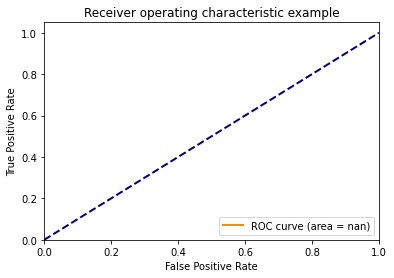

{0: nan,
 1: nan,
 2: nan,
 3: nan,
 4: nan,
 5: nan,
 6: nan,
 7: nan,
 8: nan,
 9: nan,
 10: nan,
 11: nan,
 12: nan,
 13: nan,
 14: nan,
 15: nan,
 16: nan,
 17: nan,
 18: nan,
 19: nan,
 20: nan,
 21: nan,
 22: nan,
 23: nan,
 24: nan,
 25: nan,
 26: nan,
 27: nan,
 28: nan,
 29: nan,
 30: nan,
 31: nan,
 32: nan,
 33: nan,
 34: nan,
 35: 0.5,
 36: nan,
 37: nan,
 38: nan,
 39: nan,
 40: nan,
 41: nan,
 42: nan,
 43: nan,
 44: nan,
 45: nan,
 46: nan,
 47: nan,
 48: nan,
 49: nan,
 50: nan,
 51: nan,
 52: nan,
 53: nan,
 54: nan,
 55: 0.5,
 56: nan,
 57: nan,
 58: nan,
 59: nan,
 60: nan,
 61: nan,
 62: nan,
 63: nan,
 64: nan,
 65: nan,
 66: 0.5,
 67: nan,
 68: nan,
 69: nan,
 70: nan,
 71: nan,
 72: nan,
 73: nan,
 74: nan,
 75: nan,
 76: nan,
 77: 0.5,
 78: nan,
 79: nan,
 80: nan,
 81: nan,
 82: nan,
 83: nan,
 84: nan,
 85: nan,
 86: nan,
 87: nan,
 88: nan,
 89: nan,
 90: nan,
 91: nan,
 92: nan,
 93: nan,
 94: nan,
 95: nan,
 96: nan,
 97: nan,
 98: nan,
 99: nan,
 100: nan,

In [134]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(206):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

roc_auc

In [128]:
predictions.shape

(3982, 206)

In [130]:
y_test = predictions.copy()
for i in range(10):
    y_test[random.randint(0,3981)][random.randint(0,205)] = 1


In [105]:
y_test = pd.read_csv('../input/lishmoapublicleaderboard/lish-moa-publicleaderboard.csv')

In [ ]:
# valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

# y_true = train_targets_scored[target_cols].values
# y_pred = valid_results[target_cols].values

# score = 0
# for i in range(len(target_cols)):
#     score_ = log_loss(y_true[:, i], y_pred[:, i])
#     score += score_ / target.shape[1]
    
# print("CV log_loss: ", score)    

In [ ]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.shape

[Go to Top](#0)

In [ ]:
sub

# Kindly leave an upvote Thanks 😁 🙏

# Acknowledgements

* [MoA: Pytorch-RankGauss-PCA-NN upgrade & 3D visual](https://www.kaggle.com/vbmokin/moa-pytorch-rankgauss-pca-nn-upgrade-3d-visual) Thanks for the great notebook. 
* The only value addition here is MLSMOTE the rest is picked up from the above 👆 notebook with a few adjustments.
* Do leave an upvote!!!!!!!
* MLSMOTE does seem to have potential but needs some more work IMO. Any leads here would be helpful feel free to leave a comment.


best LB before MLSMOTE - 0.01841
best LB afer MLSMOTE - 0.01844

